In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

import transformers

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter


In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 14

In [3]:
from src.utils import hex_to_str, str_to_hex
from src.train_subword import build_gpt_tokenizer


## Load FLORES dataset

In [4]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    #'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [5]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [6]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [7]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    #plt.xticks(rotation=90)
    plt.ylabel("Line avg.")
    if title:
        plt.title(title)
    plt.show()

In [8]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
   
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.set_palette(['#B2DF8A', '#FDBF6F', '#B3CDE3', '#FCCDE5', '#D9D9D9'])

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

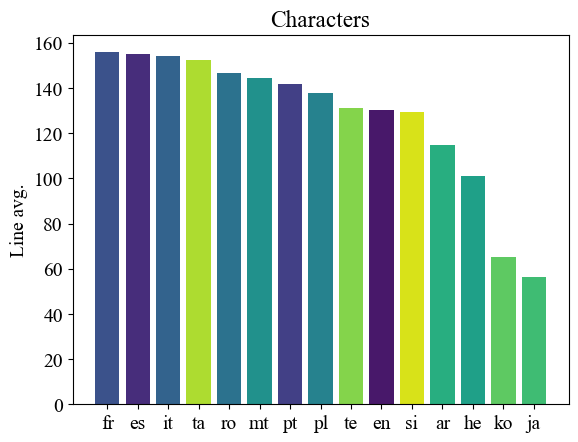

In [9]:
plot_token_numbers(flores_chars, "Characters")

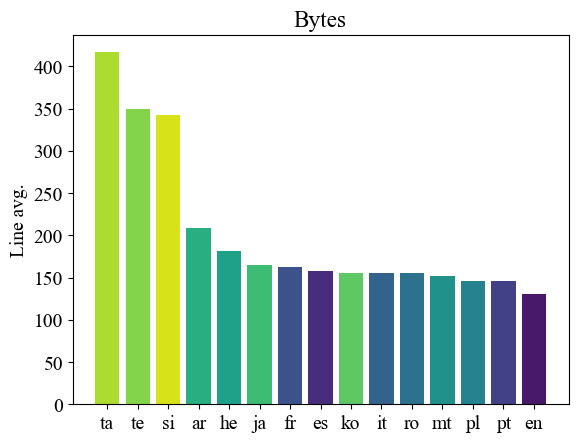

In [10]:
plot_token_numbers(flores_bytes, "Bytes")

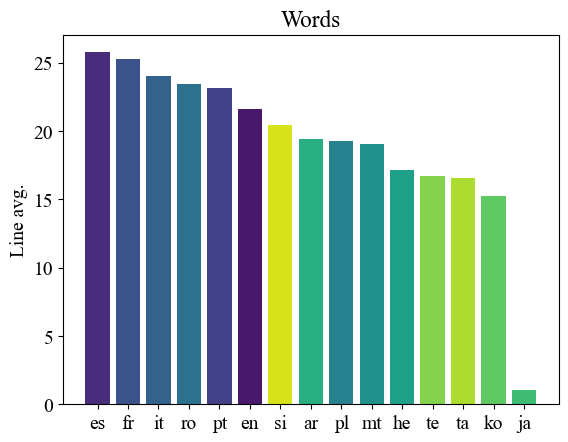

In [11]:
plot_token_numbers(flores_words, "Words")

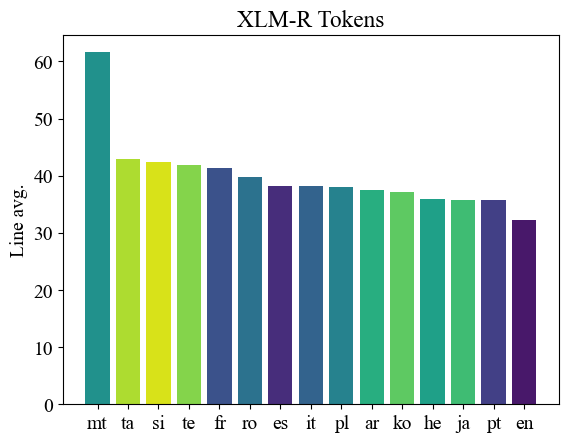

In [12]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

## Balenced BBPE on FLORES

In [13]:
split="dev"
flores_tokenizers = build_gpt_tokenizer(f"flores200_dataset/{split}/joint.{split}", [10000, 50000,100000])
flores_il_tokenizers = {}
for lang in languages:
    flores_il_tokenizers[lang] = build_gpt_tokenizer(f"flores200_dataset/{split}/{languages_flores[lang]}.{split}", [2000, 10000,20000])


In [14]:
flores_baltok = {lang: [flores_tokenizers['tokenizer_50000'].encode(line) for line in flores[lang]] for lang in flores.keys()}
flores_il_baltok = {lang: [flores_il_tokenizers[lang]['tokenizer_10000'].encode(line) for line in flores[lang]] for lang in flores.keys()}

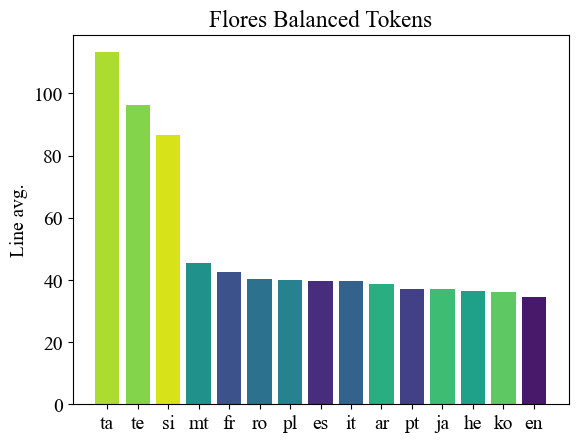

In [15]:
plot_token_numbers(flores_baltok, "Flores Balanced Tokens")

## Morfessor rewriting

In [16]:
from src.rewrite_bytes import ByteRewriter
from src.utils import str_to_hex

In [17]:
decompose_file = "byte_maps/decompose.json"
morf_all_map_file = "byte_maps/merge_map.json"
decompose_rewriter = ByteRewriter(decompose_file)
morf_all_rewriter = ByteRewriter(morf_all_map_file)

flores_decomposed_rw = {lang: [decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' ')) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_all_rw = {lang: [morf_all_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}

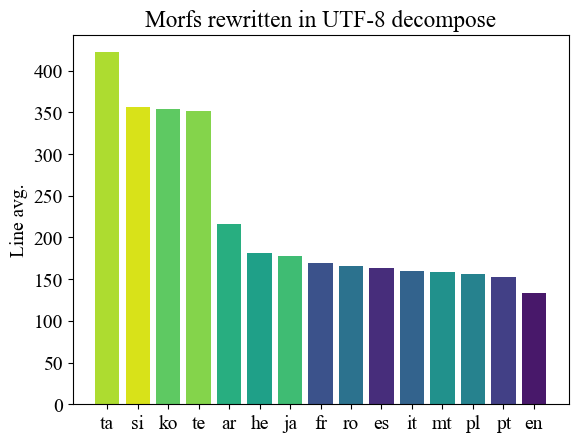

In [18]:
title = f"Morfs rewritten in UTF-8 decompose"
plot_token_numbers(flores_decomposed_rw , title)

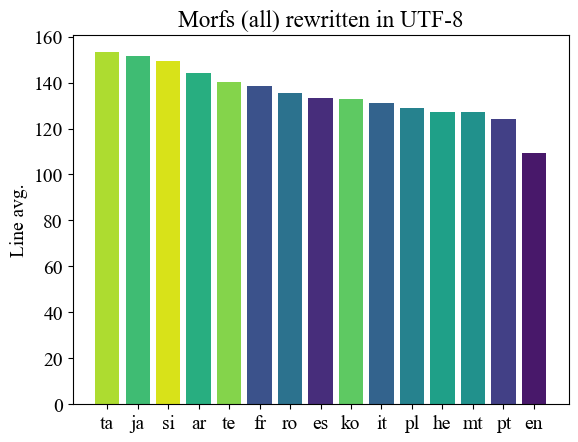

In [19]:
title = f"Morfs (all) rewritten in UTF-8"
plot_token_numbers(flores_morfs_all_rw , title)

## Compare Parity

         bytes  m. bytes (all)       chars
en  130.529644      109.140316  130.401186
es  158.046443      133.473320  155.178854
pt  145.769763      124.017787  141.787549
fr  162.081028      138.592885  155.818182
it  155.394269      130.900198  154.286561
ro  155.099802      135.288538  146.844862
pl  146.495059      129.011858  137.831028
mt  151.973320      127.160079  144.553360
he  180.910079      127.297431  100.843874
ar  208.770751      144.227273  114.940711
ja  165.127470      151.614625   56.267787
ko  155.927866      132.965415   65.182806
te  349.516798      140.265810  130.933794
ta  416.641304      153.172925  152.305336
si  341.952569      149.218379  129.525692
Means: bytes             201.615744
m. bytes (all)    135.089789
chars             127.780105
dtype: float64
Std: bytes             89.896741
m. bytes (all)    11.660276
chars             31.311394
dtype: float64


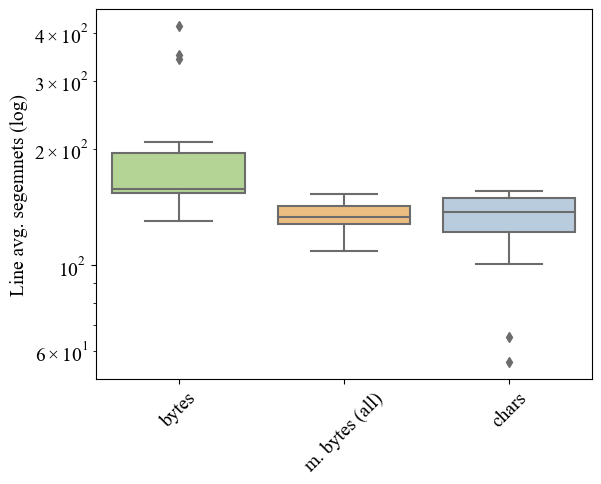

In [20]:

plot_compare_token_numbers([flores_bytes, flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes (all)','chars'])

       bytes  m. bytes (all)     chars
en  1.000000        1.000000  1.000000
es  1.210809        1.222952  1.190011
pt  1.116756        1.136315  1.087318
fr  1.241718        1.269860  1.194914
it  1.190490        1.199375  1.183168
ro  1.188234        1.239584  1.126101
pl  1.122313        1.182073  1.056977
mt  1.164282        1.165106  1.108528
he  1.385969        1.166365  0.773336
ar  1.599413        1.321485  0.881439
ja  1.265057        1.389172  0.431498
ko  1.194578        1.218298  0.499864
te  2.677681        1.285188  1.004084
ta  3.191929        1.403450  1.167975
si  2.619731        1.367216  0.993286
Means: bytes             1.544597
m. bytes (all)    1.237762
chars             0.979900
dtype: float64
Std: bytes             0.688707
m. bytes (all)    0.106837
chars             0.240116
dtype: float64


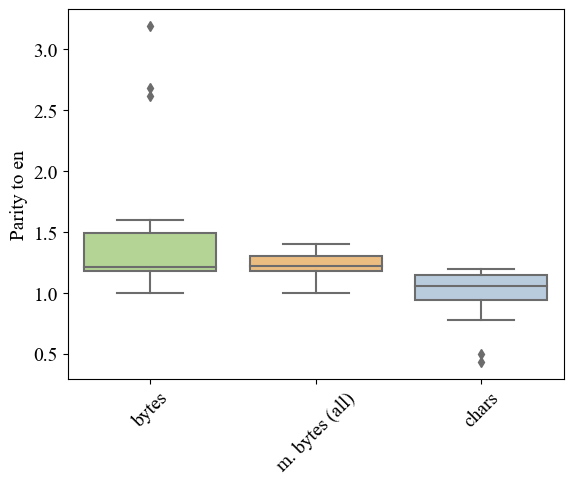

In [21]:
plot_compare_token_numbers([flores_bytes,  flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes (all)','chars'], parity='en')

In [22]:
compression_factors = []
for lang in languages:
    byte_base = sum([len(sen) for sen in flores_bytes[lang]])
    morph_base = sum([len(sen) for sen in flores_morfs_all_rw[lang]])
    compression_factors.append(1- (morph_base/byte_base))

In [23]:
sum(compression_factors) / len(compression_factors)

0.2540494085639837

In [24]:
sorted_languages, compression_factors = zip(*sorted(zip(languages, compression_factors), key=lambda item: item[1], reverse=True))

In [25]:
max(compression_factors)

0.6323626023085991

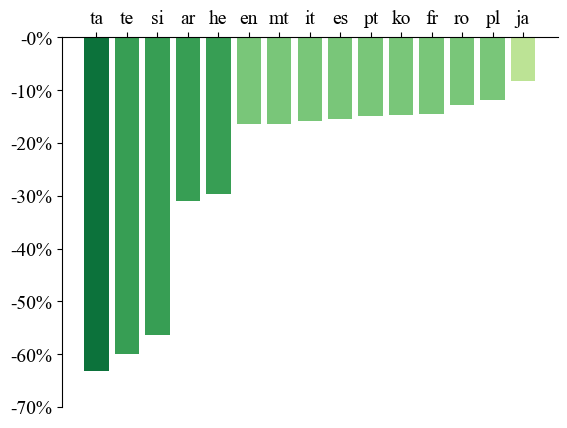

In [26]:
# plot bar plot going down from 0 to 100 %

# barplot with pall

def percent_minus_formatter(x, pos):
    return f"-{x:.0f}%"

cmap = plt.cm.get_cmap('YlGn')
norm = BoundaryNorm([-0.1, 0.01, 0.05, 0.1, 0.2,  0.6, 0.7, 0.8], cmap.N)


plt.bar(sorted_languages, np.array(compression_factors) * 100, color=cmap(norm(compression_factors)))


ax = plt.gca()
formatter = FuncFormatter(percent_minus_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params('x', top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_ylim([0.,70.])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# add percent to y ticks


ax.invert_yaxis()




plt.show()

In [27]:
compression_factors 

(0.6323626023085991,
 0.5986864982994591,
 0.5636284300806806,
 0.30915958272591304,
 0.29634970313686293,
 0.16386567344961245,
 0.1632736659362667,
 0.1576253187416936,
 0.1554803898888979,
 0.1492214562191989,
 0.14726329064189259,
 0.1449160498945289,
 0.12773236663884657,
 0.11934328479018974,
 0.08183281570711332)